In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import textwrap

### Load the Data

- Load the `train.csv` file using Pandas.


In [345]:
df = pd.read_csv('dataset/train.csv')

In [346]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Understanding the Columns

- Print the column names and their data types.
- Get information about null values.


In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            21.611722
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          83.882784
Embarked        0.244200
dtype: float64

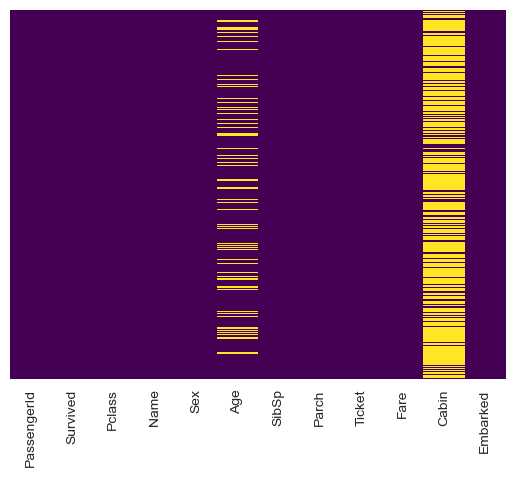

In [348]:
sns.heatmap(data=df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
df.isnull().sum()/819 * 100

Think about what to do with each missing column:

- Drop it?
- Fill it with a default or mean/median?
- Leave it for now?

### 🧠 Decision Time: How to Handle Each Column

| Column     | Missing Count | % Missing | Action                                                |
| ---------- | ------------- | --------- | ----------------------------------------------------- |
| `Age`      | 177           | ~21%      | ✅ Fill with median (safer than mean due to outliers) |
| `Cabin`    | 687           | ~83%      | ❌ Too many missing → Drop this column                |
| `Embarked` | 2             | ~0.2%     | ✅ Fill with most common value (mode)                 |


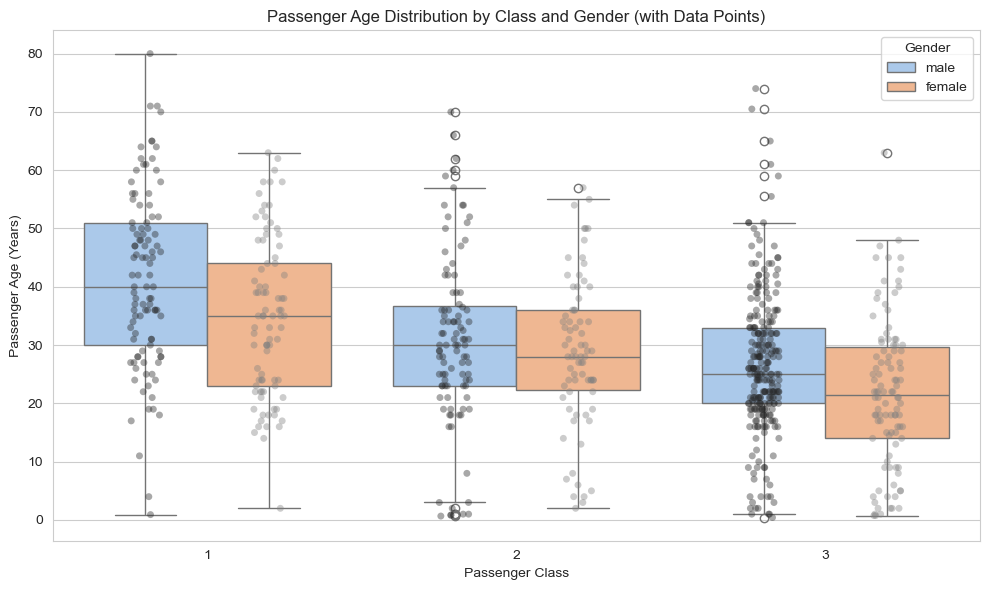

In [349]:
plt.figure(figsize=(10, 6))

# Boxplot
sns.boxplot(
    data=df,
    x='Pclass',
    y='Age',
    hue='Sex',
    hue_order=['male', 'female'],
    order=['1', '2', '3'],
    palette='pastel'
)

# Add dots (stripplot)
sns.stripplot(
    data=df,
    x='Pclass',
    y='Age',
    hue='Sex',
    hue_order=['male', 'female'],
    order=['1', '2', '3'],
    dodge=True,
    alpha=0.4,
    palette='dark:gray'
    
)

# Fix double legends (from boxplot + stripplot)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Gender')

plt.title('Passenger Age Distribution by Class and Gender (with Data Points)')
plt.xlabel('Passenger Class')
plt.ylabel('Passenger Age (Years)')
plt.tight_layout()
plt.show()

In [350]:
df.groupby(['Pclass', 'Sex'])[['Age']].median()

Age
Pclass Sex         
1      female  35.0
       male    40.0
2      female  28.0
       male    30.0
3      female  21.5
       male    25.0

### Average Age by Passenger Class and Gender

We observe the following average (mean) ages of passengers across the different classes:

- 👑 **1st Class**: Male: **40 years**, Female: **35 years**
- 🧑‍💼 **2nd Class**: Male: **30 years**, Female: **28 years**
- 🧍 **3rd Class**: Male: **25 years**, Female: **21.5 years**

🎯 **Strategy**: Fill missing ages using the **average age of each passenger class and gender**.


In [351]:
# Define median ages by class and sex
median_ages_by_class_genders = {
    (1, 'male'): 40.0,
    (1, 'female'): 35.0,
    (2, 'male'): 30.0,
    (2, 'female'): 28.0,
    (3, 'male'): 25.0,
    (3, 'female'): 21.5,
}

def fill_age(row):
    if pd.isnull(row['Age']):
        return median_ages_by_class_genders[(row['Pclass'], row['Sex'])]
    else:
        return row['Age']

df['Age'] = df.apply(fill_age, axis=1)

### Dropping the `Cabin` Column

The **`Cabin`** column contains a large number of missing values — more than **80%** of the entries are `NaN`. This makes it unreliable for meaningful analysis or modeling without heavy imputation or assumptions.


In [352]:
df.drop(columns='Cabin', inplace=True)

### Missing Values in `Embarked`

The **`Embarked`** column has only **0.2%** missing values.

🎯 **Strategy**: Fill missing entries with the **most common port** (i.e., the **mode**) — to preserve data without significant impact.


In [353]:
mode = df['Embarked'].mode()[0]
df['Embarked'] = df['Embarked'].fillna(mode)

### Fixed Missing Values — All Cleaned!

✅ The dataset is now fully clean with **zero missing values**.


In [354]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### Survival Distribution

- How many survived vs not Survived?


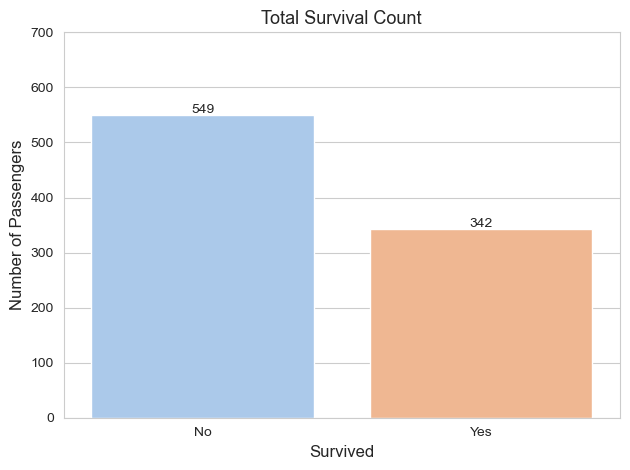

In [355]:
# Count of survivors vs non-survivors
sns.set_style("whitegrid")
count_plot = sns.countplot(x='Survived',
                           data=df,
                           hue='Survived',
                           palette='pastel',
                           legend=False)
plt.ylim(0, 700)
plt.title('Total Survival Count', fontsize=13)
plt.xlabel('Survived', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

for bar in count_plot.patches:
    count_plot.text(x=bar.get_x() + bar.get_width()/2,
                    y=bar.get_height() + 5,
                    s=f"{int(bar.get_height())}",
                    ha='center',
                    fontsize=10)

plt.tight_layout()
plt.show()

### Survival Rate Within Each Gender
- How many of men survived?. How many of women survived?  
- Which gender had a higher survival rate based on their group size?

In [356]:
men_vs_women = df[df['Survived'] == 1].groupby('Sex').size().reset_index(name='Survived')
men_vs_women

,Sex,Survived
0,female,233
1,male,109


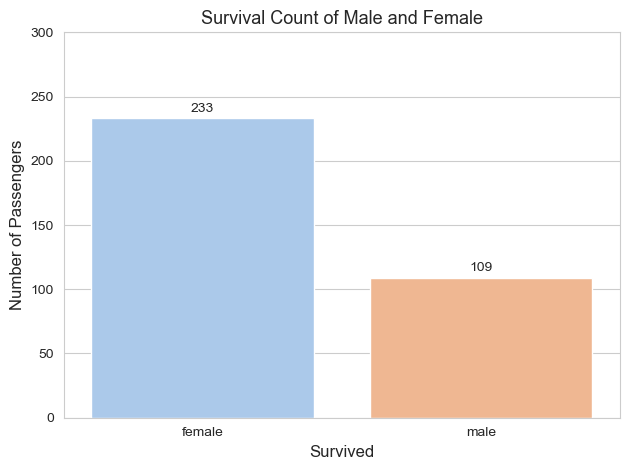

In [357]:
# Count of survivors vs non-survivors
bar_plot = sns.barplot(data=men_vs_women,
                         x='Sex',
                         y='Survived',
                         hue='Sex',
                         palette='pastel',
                         legend=False)
plt.ylim(0, 300)
plt.title('Survival Count of Male and Female', fontsize=13)
plt.xlabel('Survived', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)

for bar in bar_plot.patches:
    bar_plot.text(x=bar.get_x() + bar.get_width()/2,
                    y=bar.get_height() + 5,
                    s=f"{int(bar.get_height())}",
                    ha='center',
                    fontsize=10)

plt.tight_layout()
plt.show()

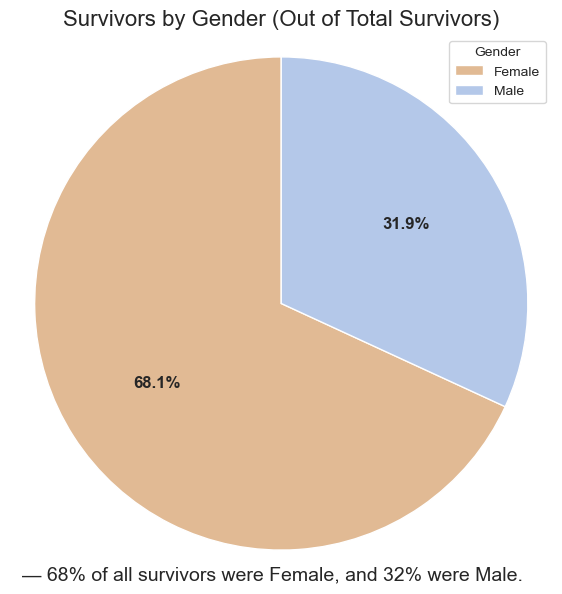

In [358]:
# Count survivors by gender
female_survivors = df.query("Sex == 'female' and Survived == 1").shape[0]
male_survivors = df.query("Sex == 'male' and Survived == 1").shape[0]

# Percentage calculations for chart description
total_survivors = female_survivors + male_survivors
female_survivor_percent = female_survivors / total_survivors * 100
male_survivor_percent = male_survivors / total_survivors * 100

sizes = [female_survivors, male_survivors]
labels = ['Female', 'Male']
colors = ["#E1BA94", "#B4C8E9"]  # Match seaborn pastel shades

figure, axis = plt.subplots(figsize=(7, 7))
pie_slices, labels_text, percent_text = axis.pie(sizes,
                                                 labels=None,
                                                 colors=colors,
                                                 autopct='%1.1f%%',
                                                 startangle=90)
axis.set_title('Survivors by Gender (Out of Total Survivors)',
               fontsize=16)
plt.legend(pie_slices, labels,
           title="Gender",
           loc="upper right")
plt.setp(percent_text, size=12, weight="bold")
axis.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.figtext(
    0.5,
    0.1,
    fontsize=14,
    s=f"— {female_survivor_percent:.0f}% of all survivors were Female, and {male_survivor_percent:.0f}% were Male.",
    wrap=True,
    horizontalalignment='center')
plt.show()

In [359]:
# Who had better survival: men or women?
men_vs_women_survival_rate = df.groupby('Sex')['Survived'].mean().reset_index()
men_vs_women_survival_rate['Survived'] *= 100
men_vs_women_survival_rate

,Sex,Survived
0,female,74.203822
1,male,18.890815


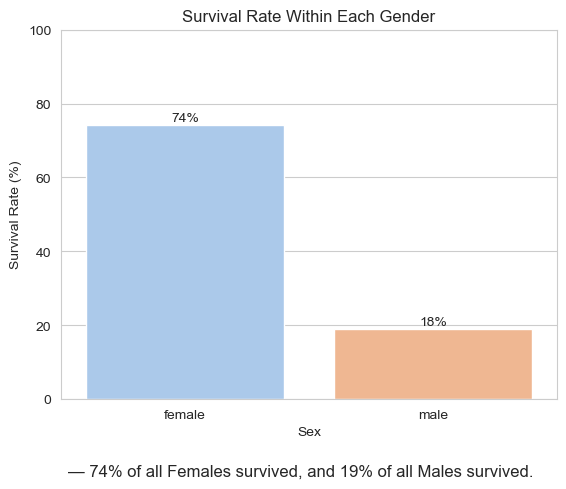

In [360]:
def gender_survival_rate(gender):
    # Selects rows where 'Sex' == gender and only the 'Survived' column.
    rate = men_vs_women_survival_rate.loc[(men_vs_women_survival_rate['Sex'] == gender),
                                          'Survived'].values[0]
    return rate


bar_plot = sns.barplot(data=men_vs_women_survival_rate,
                       x='Sex',
                       y='Survived',
                       hue='Sex',
                       legend=False,
                       palette='pastel')
plt.ylim(0, 100)
plt.title('Survival Rate Within Each Gender')
plt.ylabel('Survival Rate (%)')

for bar in bar_plot.patches:
    bar_plot.text(x=bar.get_x() + bar.get_width()/2,
                  y=bar.get_height() + 1,
                  s=f"{int(bar.get_height())}%",
                  ha='center',
                  fontsize=10)

plt.figtext(0.5, -0.05,
            f"— {gender_survival_rate('female'):.0f}% of all Females survived, and {gender_survival_rate('male'):.0f}% of all Males survived.",
            wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

### Survival Rate by Passenger Class
- Did passengers in higher classes have a better chance of survival?  
- How did survival rates vary between males and females across 1st, 2nd, and 3rd class travelers? 
- Was 1st class significantly safer than the others?


In [361]:
pclass_survival_rate = df.groupby('Pclass')['Survived'].mean().reset_index()
pclass_survival_rate['Survived'] *= 100
pclass_survival_rate

,Pclass,Survived
0,1,62.962963
1,2,47.282609
2,3,24.236253


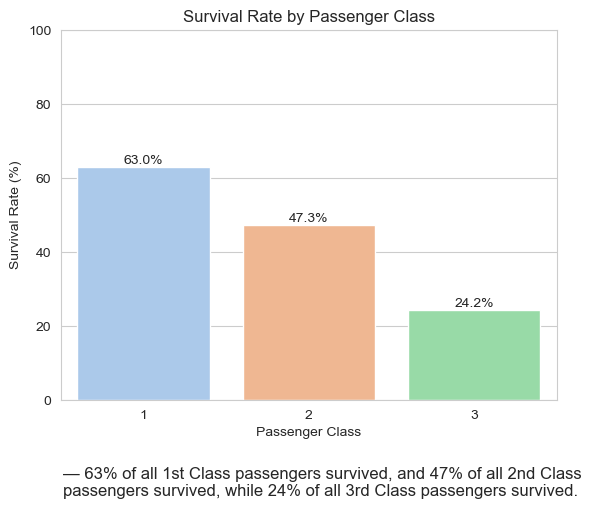

In [362]:
# Did passengers in higher classes have a better chance of survival? 
pclass_survival_rate = df.groupby('Pclass')['Survived'].mean().reset_index()
pclass_survival_rate['Survived'] *= 100

sns.barplot(data=pclass_survival_rate,
            x='Pclass',
            y='Survived',
            hue='Pclass',
            legend=False,
            palette='pastel')

plt.ylabel('Survival Rate (%)')
plt.xlabel('Passenger Class')
plt.title('Survival Rate by Passenger Class')

# Annotate values
for index, row in pclass_survival_rate.iterrows():
    plt.text(x=index, y=row['Survived'] + 1, s=f"{row['Survived']:.1f}%", ha='center')


txt = f"— {pclass_survival_rate['Survived'][0]:.0f}% of all 1st Class passengers survived, and {pclass_survival_rate['Survived'][1]:.0f}% of all 2nd Class passengers survived, while {pclass_survival_rate['Survived'][2]:.0f}% of all 3rd Class passengers survived."
wrapped_txt = textwrap.fill(txt, width=68)  # try width=60-80 depending on figure size

plt.figtext(0.129, -0.09, wrapped_txt, horizontalalignment='left', fontsize=12)
plt.ylim(0, 100)
plt.show()


In [363]:
pclass_gender_survival_rate = df.groupby(['Pclass','Sex'])['Survived'].mean().reset_index()
pclass_gender_survival_rate['Survived'] *= 100
pclass_gender_survival_rate

,Pclass,Sex,Survived
0,1,female,96.808511
1,1,male,36.885246
2,2,female,92.105263
3,2,male,15.740741
4,3,female,50.000000
5,3,male,13.544669


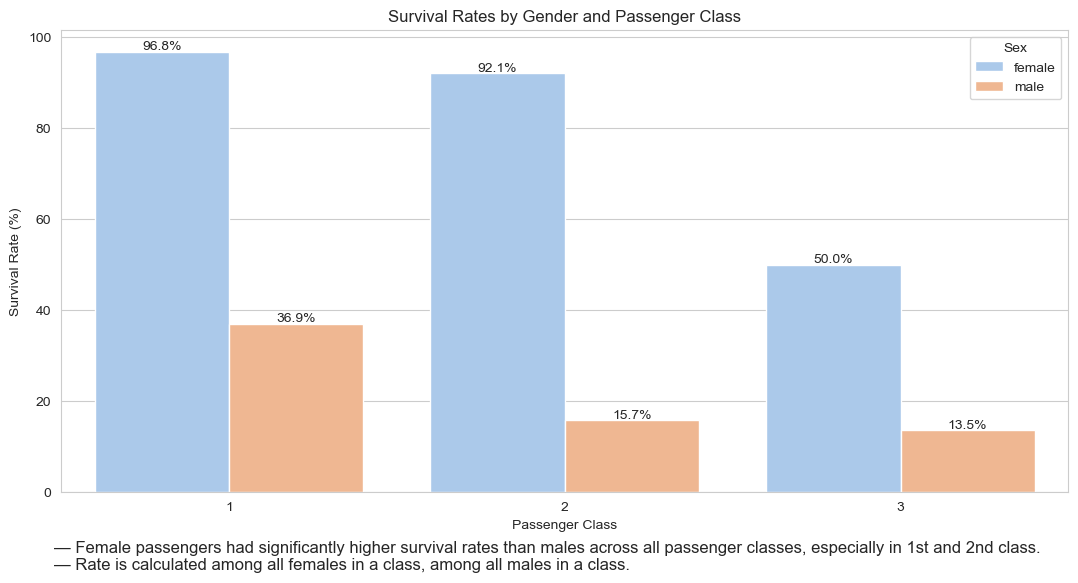

In [364]:
plt.figure(figsize=(13, 6))

barplot = sns.barplot(data=pclass_gender_survival_rate,
                      x='Pclass', y='Survived', hue='Sex', palette='pastel')
sns.set_style('whitegrid')

plt.title('Survival Rates by Gender and Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate (%)')

for bar in barplot.patches:
    # This skips dummy bars (zero height + zero width)
    if bar.get_height() == 0 and bar.get_width() == 0:
        continue
    barplot.text(x=bar.get_x() + bar.get_width()/2,
                 y=bar.get_height() + 0.5,
                 s=f"{bar.get_height():.1f}%",
                 ha='center',
                 fontsize=10)

txt = f"""— Female passengers had significantly higher survival rates than males across all passenger classes, especially in 1st and 2nd class. 
— Rate is calculated among all females in a class, among all males in a class."""
wrapped_txt = textwrap.fill(txt, width=133)  # try width=60-80 depending on figure size

plt.figtext(0.12, -0.02, wrapped_txt, horizontalalignment='left', fontsize=12)
plt.show()

### 🧠 Insight: Passenger Titles Influence Survival

💡 Including a `Title` feature derived from `Name` helps uncover hidden patterns in the data.


In [365]:
# Extract titles using regular expression
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

officer_titles = ['Capt', 'Col', 'Major', 'Dr', 'Rev']
df['Title'] = df['Title'].replace(officer_titles, 'Crew')

title_map = {
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Don": "Royalty",
    "Sir": "Royalty",
    "Lady": "Royalty",
    "the Countess": "Royalty",
    "Jonkheer": "Royalty"}
df['Title'] = df['Title'].replace(title_map)

df['Title'].value_counts()

Title
Mr         517
Miss       185
Mrs        126
Master      40
Crew        18
Royalty      5
Name: count, dtype: int64

We observed that **titles extracted from the `Name` column** (such as _Royalty, _Mrs._, _Miss_, _Master_, etc.) have a noticeable effect on the **survival rate**.

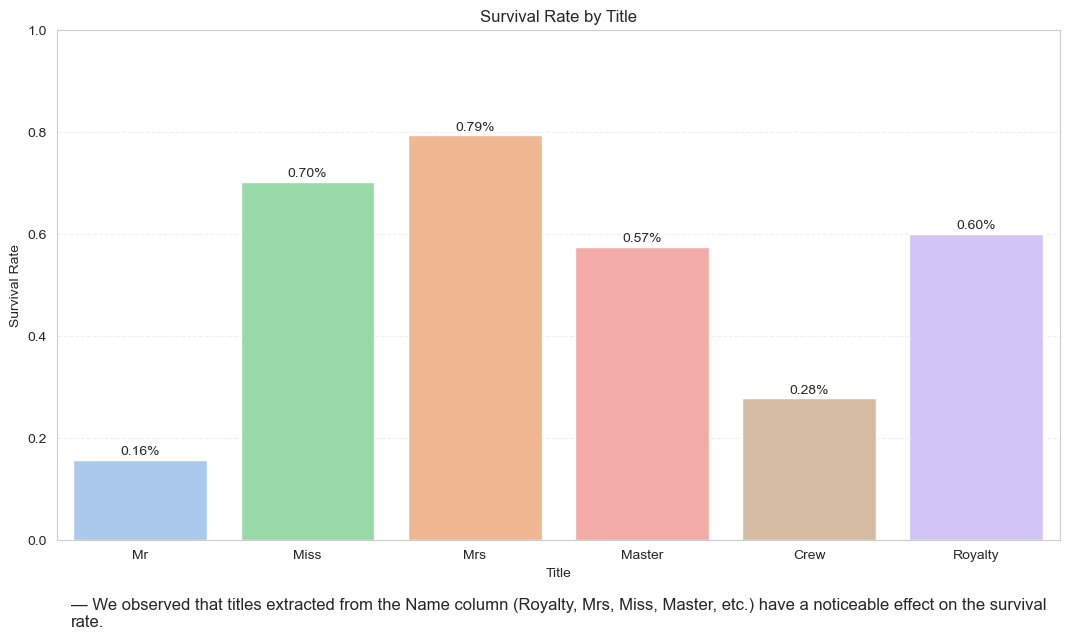

In [366]:
# Barplot: survival rate by title
plt.figure(figsize=(10.8, 6))
barplot = sns.barplot(data=df, x='Title', y='Survived', estimator='mean', hue='Title',
                      errorbar=None, order=df['Title'].value_counts().index, palette='pastel')
plt.ylim(0, 1)
plt.title('Survival Rate by Title')
plt.ylabel('Survival Rate')
plt.xlabel('Title')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for bar in barplot.patches:
    barplot.text(x=bar.get_x() + bar.get_width()/2,
                 y=bar.get_height() + 0.01,
                 s=f"{bar.get_height():.2f}%",
                 ha='center',
                 fontsize=10)

txt = f"— We observed that titles extracted from the Name column (Royalty, Mrs, Miss, Master, etc.) have a noticeable effect on the survival rate."
plt.figtext(0.07, -0.05,
            s=txt,
            wrap=True,
            horizontalalignment='left',
            fontsize=12)
plt.tight_layout()
plt.show()

### Age Distribution  
   - Categorized passengers by age and survival rate by groups
   - Visualized age distribution by class and gender using a box
   - Plot age distribution for survived vs. not survived

In [367]:
df['Age'].describe()

count    891.000000
mean      29.112424
std       13.304424
min        0.420000
25%       21.500000
50%       26.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

In [368]:
# Categorize age groups
def age_category(age):
    if age <= 12:
        return 'Children (0–12)'
    elif age <= 19:
        return 'Teenagers (13–19)'
    elif age <= 35:
        return 'Young Adults (20–35)'
    elif age <= 59:
        return 'Middle-Aged (36–59)'
    else:
        return 'Elderly (60+)'

df['AgeGroup'] = df['Age'].apply(age_category)

In [369]:
age_group_counts = df['AgeGroup'].value_counts().reset_index()
age_group_counts 

,AgeGroup,count
0,Young Adults (20–35),489
1,Middle-Aged (36–59),212
2,Teenagers (13–19),95
3,Children (0–12),69
4,Elderly (60+),26


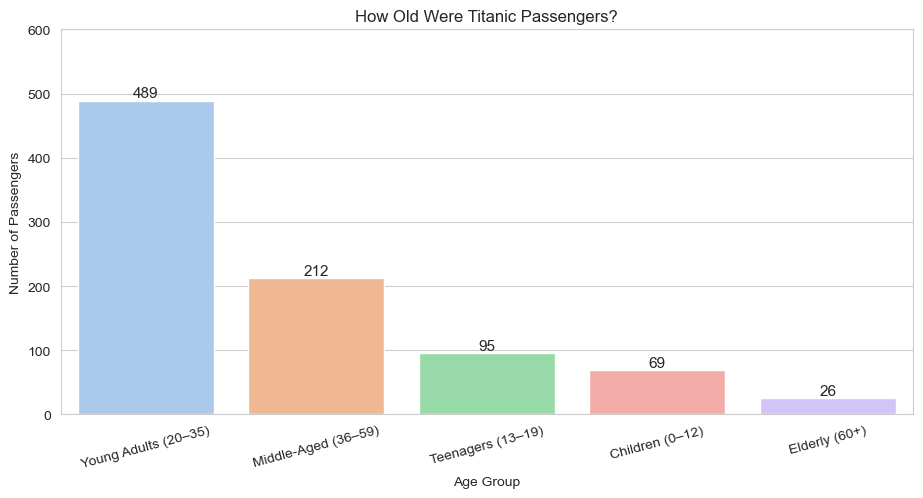

In [370]:
plt.figure(figsize=(11, 5))
bars = sns.barplot(data=age_group_counts,
                   x='AgeGroup',
                   y='count',
                   hue='AgeGroup',
                   palette='pastel')
plt.title('How Old Were Titanic Passengers?')
plt.xlabel('Age Group')
plt.ylabel('Number of Passengers')

# Add count labels on top of bars
for bar in bars.patches:
    y_val = bar.get_height()
    bars.text(x=bar.get_x() + bar.get_width() / 2,
              y=bar.get_height() + 5,
              s=int(y_val),
              ha='center',
              fontsize=11)

plt.xticks(rotation=15)
plt.ylim(0, 600)
plt.show()

In [371]:
# Group by AgeGroup and calculate survival rate
survival_rate_by_age_group = df.groupby('AgeGroup')['Survived'].mean().sort_values(ascending=False)

# Display the result
print(survival_rate_by_age_group)


AgeGroup
Children (0–12)         0.579710
Teenagers (13–19)       0.410526
Middle-Aged (36–59)     0.382075
Young Adults (20–35)    0.357873
Elderly (60+)           0.269231
Name: Survived, dtype: float64


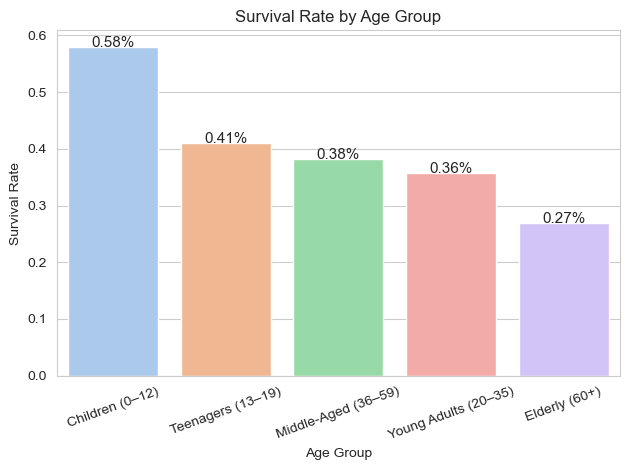

In [372]:
# Barplot of survival rates by age group
bar_plot = sns.barplot(x=survival_rate_by_age_group.index,
                       y=survival_rate_by_age_group.values,
                       hue=survival_rate_by_age_group.index,
                       palette='pastel')

plt.title('Survival Rate by Age Group')
plt.ylabel('Survival Rate')
plt.xlabel('Age Group')

for bar in bar_plot.patches:
    y_val = bar.get_height()
    bar_plot.text(x=bar.get_x() + bar.get_width() / 2,
              y=y_val,
              s=f"{y_val:.2f}%",
              ha='center',
              fontsize=11)

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

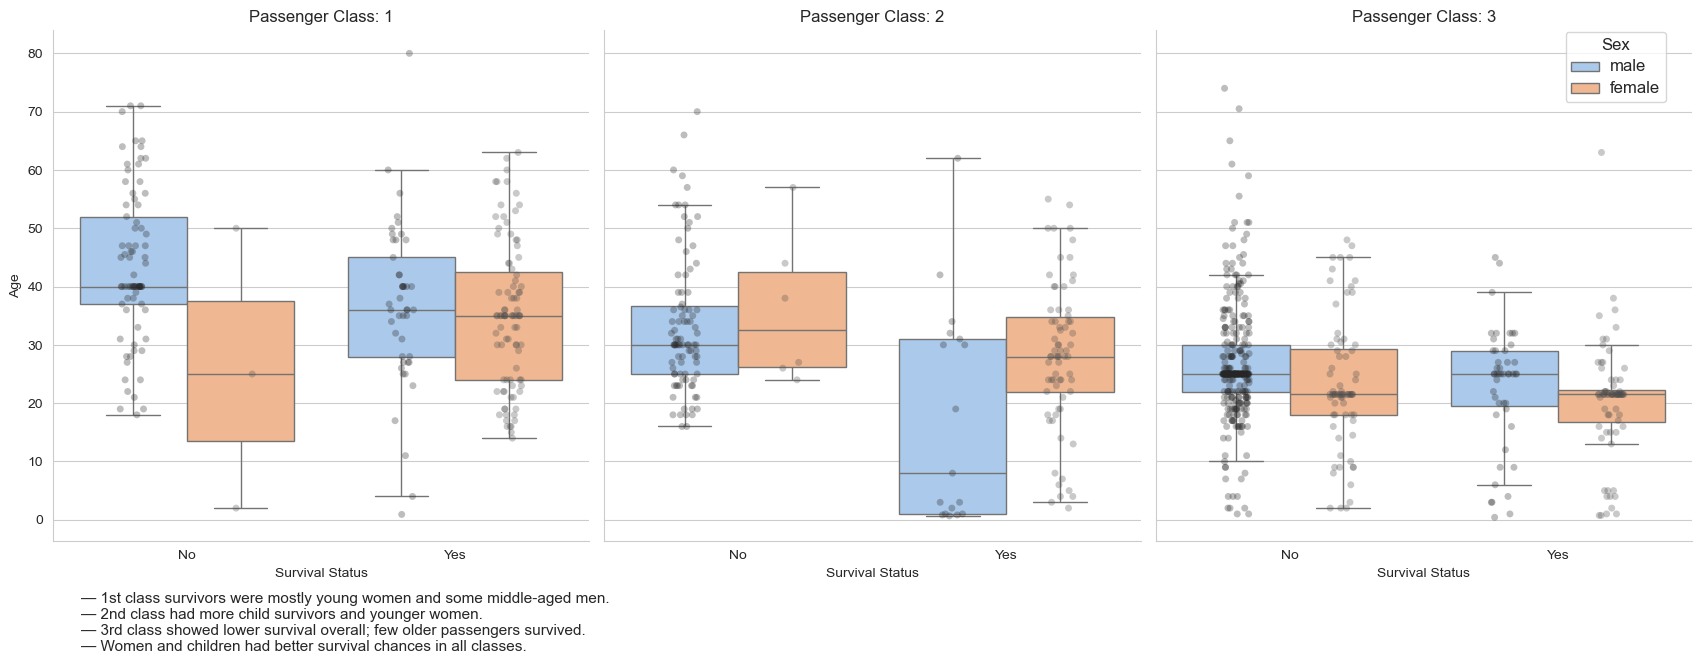

In [373]:
# Create faceted box + strip plot by Pclass
df_age_survived = df[['Age', 'Pclass','Survived','Sex']].copy()
df_age_survived['Survived'] = df_age_survived['Survived'].map({0: 'No',
                                                               1: 'Yes'})
cat_plot = sns.catplot(
    data=df_age_survived,
    x='Survived',
    y='Age',
    hue='Sex',
    hue_order=['male', 'female'],
    col='Pclass',
    legend=True,
    kind='box',
    palette='pastel',
    height=6,
    aspect=0.9,
    showfliers=False
)

# Add stripplot overlay to each facet (requires looping manually)
for ax, pclass in zip(cat_plot.axes.flat, sorted(df_age_survived['Pclass'].unique())):
    sns.stripplot(
        data=df_age_survived[df_age_survived['Pclass'] == pclass],
        x='Survived',
        y='Age',
        hue='Sex',
        hue_order=['male', 'female'],
        dodge=True,
        palette='dark:.3',
        legend=False,
        alpha=0.3,
        ax=ax
    )
    ax.set_title(f'Passenger Class: {pclass}')
    ax.set_xlabel('Survival Status')

legend = cat_plot._legend
legend.set_bbox_to_anchor((0.98, 0.95),transform=cat_plot.fig.transFigure)
legend.set_loc('upper right')
legend.set_title("Sex", prop={'size': 12})     
for text in legend.texts:
    text.set_fontsize(12)
legend.set_frame_on(True)  

# Add interpretation text
txt = """— 1st class survivors were mostly young women and some middle-aged men.
— 2nd class had more child survivors and younger women.
— 3rd class showed lower survival overall; few older passengers survived.
— Women and children had better survival chances in all classes."""
plt.figtext(0.05, -0.09, txt, fontsize=11, ha='left', wrap=True)
plt.xlabel('Survival Status')
plt.tight_layout()
plt.show()

### Fare Distribution
   - Did people who paid more have better chances?
   - What were ticket price ranges?

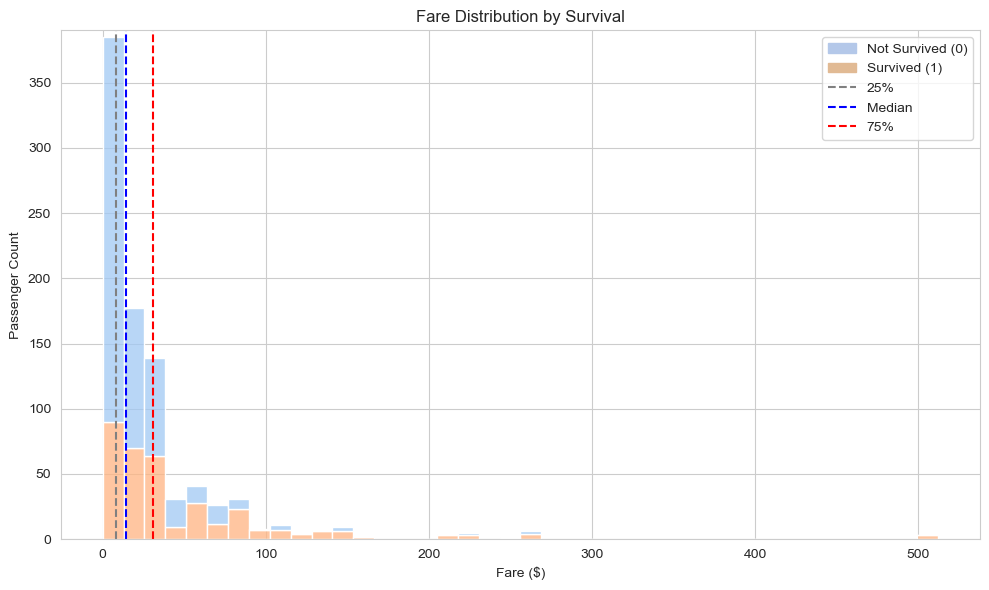

In [374]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x='Fare',
    hue='Survived',
    multiple='stack',
    bins=40,
    palette='pastel')
plt.ylim(0, 390)  # or any value that helps reveal detail
# Add percentile lines
q1 = df['Fare'].quantile(0.25)
q2 = df['Fare'].median()
q3 = df['Fare'].quantile(0.75)

plt.axvline(q1, color='gray', linestyle='--', label='25%')
plt.axvline(q2, color='blue', linestyle='--', label='Median')
plt.axvline(q3, color='red', linestyle='--', label='75%')

# Title and labels
plt.title('Fare Distribution by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('Passenger Count')

# Custom legend handles
survived_0 = mpatches.Patch(color=colors[1], label='Not Survived (0)')
survived_1 = mpatches.Patch(color=colors[0], label='Survived (1)')
p25 = plt.Line2D([0], [0], color='gray', linestyle='--', label='25%')
p50 = plt.Line2D([0], [0], color='blue', linestyle='--', label='Median')
p75 = plt.Line2D([0], [0], color='red', linestyle='--', label='75%')

# Add combined legend
plt.legend(handles=[survived_0, survived_1, p25, p50, p75])
plt.tight_layout()
plt.show()

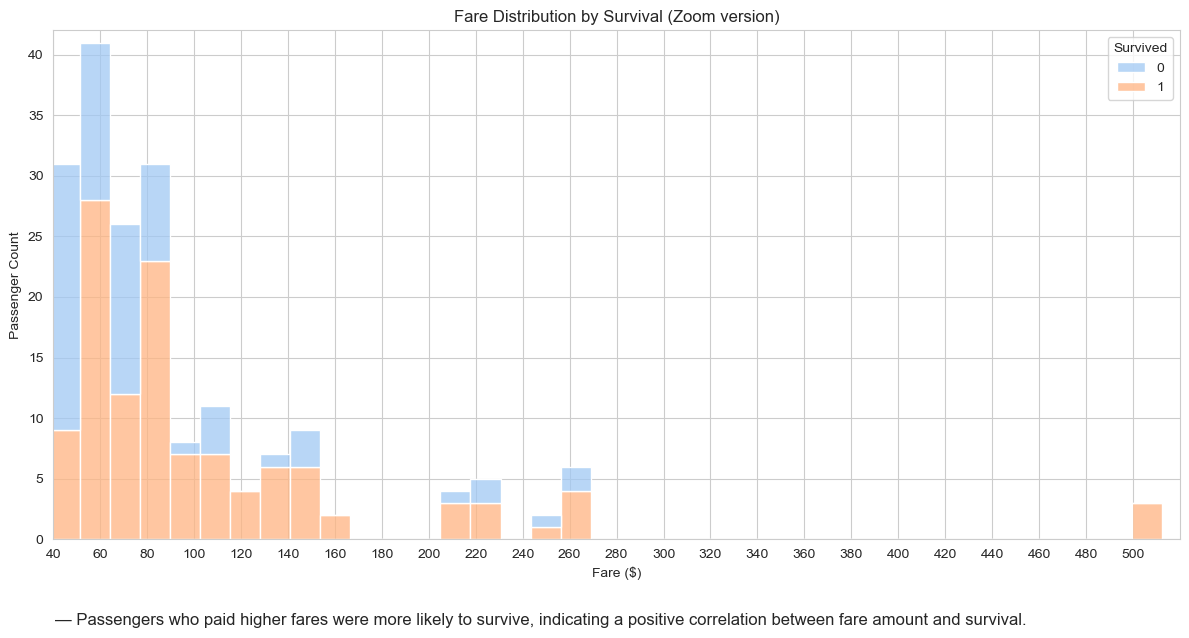

In [375]:
plt.figure(figsize=(12, 6))
ax=sns.histplot(data=df, x='Fare', hue='Survived', bins=40, multiple='stack', palette='pastel')
plt.xlim(40, 520)  
plt.ylim(0, 42) 

# Set dense grid (y-axis every 10 units)
y_max = ax.get_ylim()[1]
x_max = ax.get_xlim()[1]
ax.set_xticks(np.arange(40, x_max, 20))
ax.set_yticks(np.arange(0, y_max, 5))

plt.title('Fare Distribution by Survival (Zoom version)')
plt.xlabel('Fare ($)')
plt.ylabel('Passenger Count')
txt = f"— Passengers who paid higher fares were more likely to survive, indicating a positive correlation between fare amount and survival."
plt.figtext(0.05, -0.05,
            s=txt,
            wrap=True,
            horizontalalignment='left',
            fontsize=12)
plt.tight_layout()
plt.show()

### 👨‍👩‍👧‍👦 Family-Based Features

We added new information about each passenger’s family. This helps us see whether someone was traveling alone or with others.

💡 Including FamilySize and IsAlone helps reveal group dynamics and capture their impact on survival chances.


In [376]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

In [377]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Title        891 non-null    object 
 12  AgeGroup     891 non-null    object 
 13  FamilySize   891 non-null    int64  
 14  IsAlone      891 non-null    int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 104.5+ KB


In [379]:
# Group by FamilySize
family_stats = df.groupby('FamilySize').agg(
    Count=('Survived', 'count'),
    SurvivalRate=('Survived', 'mean')
).reset_index()

# Optional: Sort by FamilySize
family_stats = family_stats.sort_values('FamilySize')

# Display
family_stats


,FamilySize,Count,SurvivalRate
0,1,537,0.303538
1,2,161,0.552795
2,3,102,0.578431
3,4,29,0.724138
4,5,15,0.200000
5,6,22,0.136364
6,7,12,0.333333
7,8,6,0.000000
8,11,7,0.000000


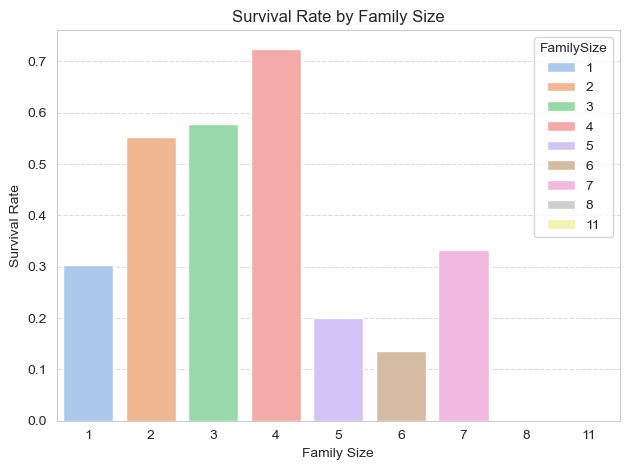

In [381]:
# Plot survival rate vs family size
sns.barplot(data=family_stats, x='FamilySize', y='SurvivalRate',
            hue='FamilySize', palette='pastel')
plt.title('Survival Rate by Family Size')
plt.ylabel('Survival Rate')
plt.xlabel('Family Size')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Survival Rate by Embarkation Port

In [384]:
port = df.groupby(['Embarked', 'Pclass'])[['Embarked']].count()
compare = df.groupby(['Embarked', 'Pclass','Survived'])['Embarked'].count()
port

Embarked
Embarked Pclass          
C        1             85
         2             17
         3             66
Q        1              2
         2              3
         3             72
S        1            129
         2            164
         3            353

In [385]:
compare

Embarked  Pclass  Survived
C         1       0            26
                  1            59
          2       0             8
                  1             9
          3       0            41
                  1            25
Q         1       0             1
                  1             1
          2       0             1
                  1             2
          3       0            45
                  1            27
S         1       0            53
                  1            76
          2       0            88
                  1            76
          3       0           286
                  1            67
Name: Embarked, dtype: int64

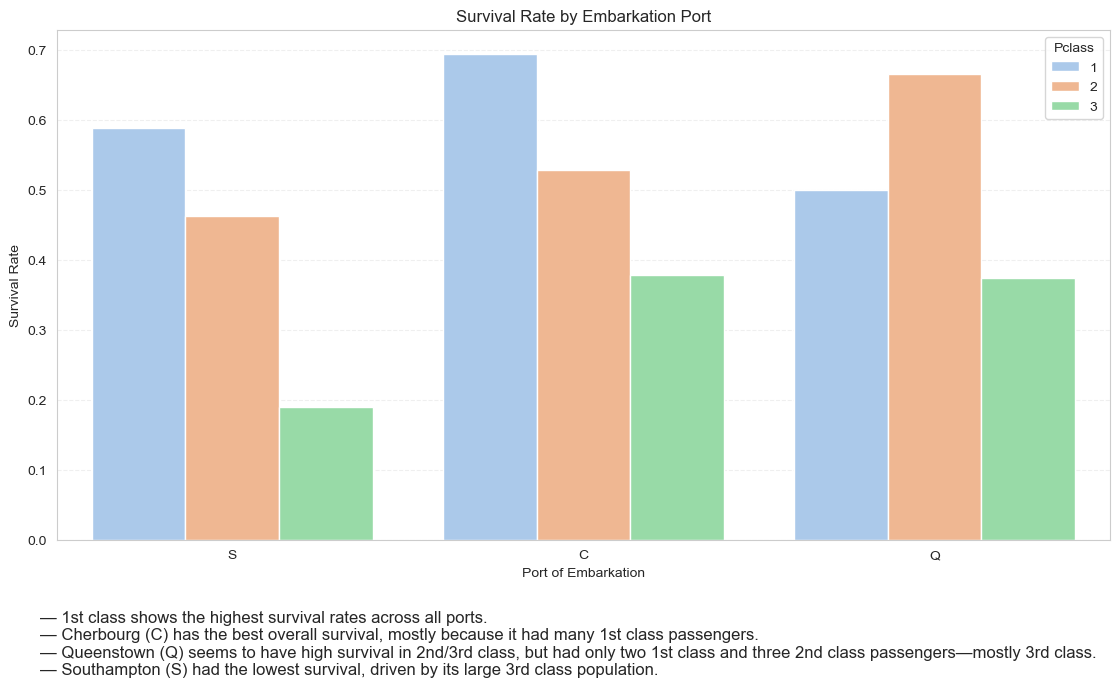

In [383]:
# Grouped barplot: survival rate by embarkation port
plt.figure(figsize=(11.3, 6))
sns.barplot(data=df,
            x='Embarked',
            y='Survived',
            hue='Pclass',
            # legend=True,
            estimator='mean',
            errorbar=None,
            palette='pastel')
plt.title('Survival Rate by Embarkation Port')
plt.ylabel('Survival Rate')
plt.xlabel('Port of Embarkation')
plt.grid(axis='y', linestyle='--', alpha=0.3)

txt = f"""— 1st class shows the highest survival rates across all ports.
— Cherbourg (C) has the best overall survival, mostly because it had many 1st class passengers.
— Queenstown (Q) seems to have high survival in 2nd/3rd class, but had only two 1st class and three 2nd class passengers—mostly 3rd class.
— Southampton (S) had the lowest survival, driven by its large 3rd class population."""

plt.figtext(0.04, -0.13,
            s=txt,
            wrap=True,
            horizontalalignment='left',
            fontsize=12)
plt.tight_layout()
plt.show()

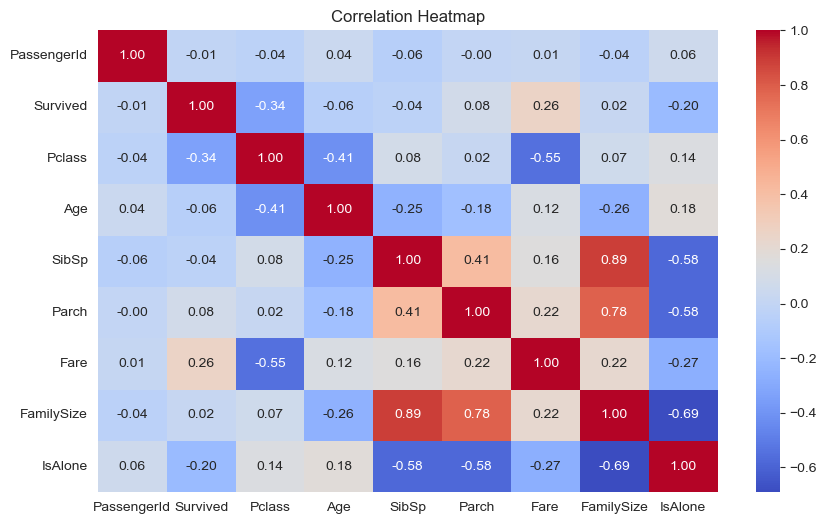

In [386]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
